<a /a>

###Set up environment 

In [ ]:
#Import all packages for your workplace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import keras

###Download packages

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='12GGm8KcaNmBUYjBQug4rQ4yQQp9PzisE', dest_path='./Model.zip', unzip=True)
!rm Model.zip

Unzipping...Done.


In [ ]:
df = pd.read_csv("/content/WHO-COVID-19-global-data.csv") #Your path to the csv file goes here
df = df.rename(columns={"Date_reported":"Date"})
frame1 = df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df_copy = df.copy()
frame1

In [ ]:
c_actual = "#00FF00"
c_predict = '#CC6600'

#Data Preparation


The function below is used to group and extract the information
from the initial frame, with respect to one of two columns: Country_code
or Country. The function will return only a dictionary or a new_frame of extracted 
information and a dictionary
*Dictionary: key: corresponding to the value in the column chosen

Ex: If <country_group_name> is Country_code, then keys will be "AF", "AL",...
    If <country_group_name> is Country, then keys will be "Afganistan, Albania,..."

              value: the frame with information extracted within the range of date given, corresponding to 
                      the key.
If you want to export a new frame contanining all of information extracted, then <export> = True will return 
a new frame satisfying the command.\
We will extract raw data in the period of **'2020-01-03' - '2021-03-31'** for the train and validation set, and **'2021-04-1 - 2021-06-07** for the test set.

In this section, we also implemented some utility functions to handle the preprocess the raw data extracted from the inital frame, namely\
1. '**prepare_data**' to extract the feature from inital frame and normalizing the data extracted.
2. '**train_test_split**' to split the dataset into train set and validation set with ratio of 8:2 (8 train : 2 validation).
3. '**prepare_data_model**' to transform the inital dataset into supervised learning dataset, respect to the number of lag-day chosen.
4. '**inverse_data**' to scale up the value to the state before being normalized.

In [ ]:
JUMP = step = 7 #TIME_STEPS

In [ ]:
def extract_group(frame, country_group_name, start_day, end_day, export = True, reset_index = True):
    group_feature = frame.groupby([country_group_name])
    group_name_list = []
    extracted_dict = dict()
    idx = 0
  
    for item in group_feature:
        group_name_list.append(item[0])
        
    for item in group_feature:
        new_frame = item[1]
        date_col = list(frame["Date"].to_numpy())
        start, end = date_col.index(start_day), date_col.index(end_day)
        new_frame = new_frame[start:end]
        extracted_dict[group_name_list[idx]] = new_frame
        idx += 1
    new_frame = pd.DataFrame(columns = frame.columns)
    for key in extracted_dict.keys():
      if not reset_index:
        new_frame = pd.concat([new_frame, extracted_dict[key]])
      else:
        new_frame = pd.concat([new_frame, extracted_dict[key].reset_index()])
    new_frame.to_csv("Data_covid-v1.csv")
    if export:
      return extracted_dict, new_frame
    else:
      return extracted_dict

In [ ]:
country_dict_train = extract_group(frame1, "Country", "1/3/2020", "6/7/2021", False, False)

In [ ]:
#Extract the frame of six selected countries
US = country_dict_train["United States of America"] 
India = country_dict_train["India"]
Brazil = country_dict_train["Brazil"]
Vietnam = country_dict_train["Viet Nam"]
Japan = country_dict_train["Japan"]
Korea = country_dict_train["Republic of Korea"]
US["Date"] = pd.to_datetime(US["Date"])
India["Date"] = pd.to_datetime(India["Date"])
Brazil["Date"] = pd.to_datetime(Brazil["Date"])
Vietnam["Date"] = pd.to_datetime(Vietnam["Date"])
Japan["Date"] = pd.to_datetime(Japan["Date"])
Korea["Date"] = pd.to_datetime(Korea["Date"])

In [ ]:
def prepare_data(frame, start_day, end_day,category):
        frame_tmp = frame.loc[(frame["Date"] >= start_day) & (frame["Date"] <= end_day)]
        raw = frame_tmp.groupby(["Date"])[["New_cases", "New_deaths"]].sum().reset_index()
        raw_data = list(raw[category].to_numpy(dtype = np.float64))
        raw_data =[x for x in raw_data if x >= 0]
        raw_data = np.array(raw_data)
        max, min = np.amax(raw_data),np.amin(raw_data)
        raw_data = (raw_data - min)/(max - min)
        return raw_data

def inverse_data(dataset, max, min):
        return dataset * population

### Received the normalized data
def train_test_split(dataset, ratio):
    k = int(ratio*len(dataset))+1
    train = dataset[:k]
    val = dataset[k:]
    return train, val

def prepare_data_model(dataset, jump):
    train, label = [], []
    x = dataset.copy()
    x = list(x)
    for i in range(len(x)- jump):
        train.append([x[i:i+jump]])
        label.append([x[i+jump]])
    train = np.array(train)
    train = train.reshape(train.shape[0], jump, train.shape[1])
    return train, np.array(label)


### Global Dataset

In [ ]:
train_gen = prepare_data(df_copy, "2020-01-03", "2021-03-31","New_cases")
test_gen = prepare_data(df_copy, '2021-04-01', '2021-06-07', "New_cases")
train_dis, val_dis = train_test_split(train_gen, .8)
wld_x_train, wld_y_train = prepare_data_model(train_dis, 7)
wld_x_val, wld_y_val = prepare_data_model(val_dis, 7)
wld_x_test, wld_y_test = prepare_data_model(test_gen, 7)
print(wld_x_train.shape,wld_x_val.shape, wld_x_test.shape)

(357, 7, 1) (83, 7, 1) (61, 7, 1)


###USA - India - Brazil Dataset

Train shape (x - y) (357, 7, 1) (357, 1)
Validation shape (x-y) (83, 7, 1) (83, 1)
Test shape (x-y) (60, 7, 1) (60, 1)


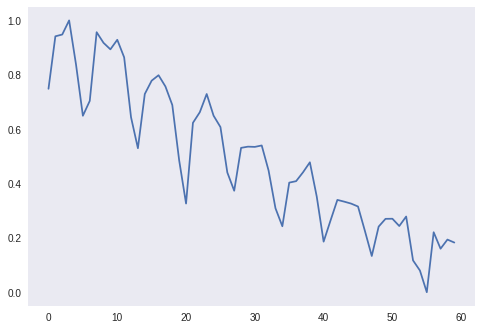

In [ ]:
#USA
US_train_gen= prepare_data(US, "2020-01-03","2021-03-31", "New_cases")
US_test_gen = prepare_data(US, "2021-04-01","2021-06-07","New_cases")

train, val = train_test_split(US_train_gen, 0.8)
us_x_train, us_y_train = prepare_data_model(train, step)
us_x_val, us_y_val = prepare_data_model(val, step)
us_x_test, us_y_test = prepare_data_model(US_test_gen, step)

print("Train shape (x - y)", us_x_train.shape, us_y_train.shape)
print("Validation shape (x-y)", us_x_val.shape, us_y_val.shape)
print("Test shape (x-y)", us_x_test.shape, us_y_test.shape)
plt.style.use('seaborn')
plt.grid(False)
plt.plot(us_y_test.copy().flatten())

(357, 7, 1) (83, 7, 1) (60, 7, 1)


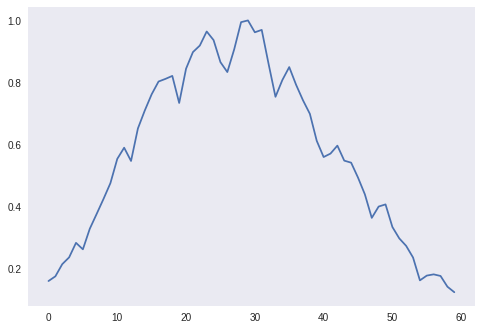

In [ ]:
#India
Ind_train_gen= prepare_data(India, "2020-01-03","2021-03-31","New_cases")
Ind_test_gen = prepare_data(India, "2021-04-1","2021-06-07","New_cases")

train, val = train_test_split(Ind_train_gen, 0.8)
ind_x_train, ind_y_train = prepare_data_model(train, step)
ind_x_val, ind_y_val = prepare_data_model(val, step)
ind_x_test, ind_y_test = prepare_data_model(Ind_test_gen, step)
plt.style.use('seaborn')
plt.grid(False)
plt.plot(ind_y_test.copy().flatten())
print(ind_x_train.shape, ind_x_val.shape, ind_x_test.shape)

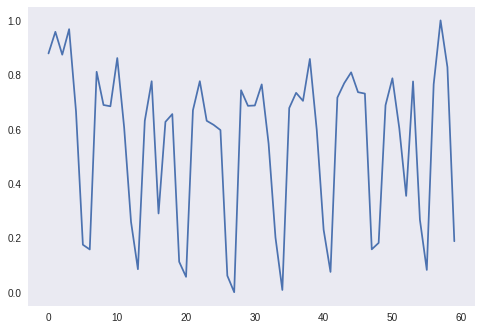

In [ ]:
#Brazil

Bra_train_gen= prepare_data(Brazil, "2020-01-03","2021-03-31","New_cases")
Bra_test_gen = prepare_data(Brazil, "2021-04-1","2021-06-07","New_cases")


train, val = train_test_split(Bra_train_gen, 0.8)
bra_x_train, bra_y_train = prepare_data_model(train, step)
bra_x_val, bra_y_val = prepare_data_model(val, step)
bra_x_test, bra_y_test = prepare_data_model(Bra_test_gen, step)
plt.style.use('seaborn')
plt.grid(False)
plt.plot(bra_y_test.copy().flatten())

### Vietnam - Korea - Japan Dataset

(356, 7, 1) (83, 7, 1) (60, 7, 1)


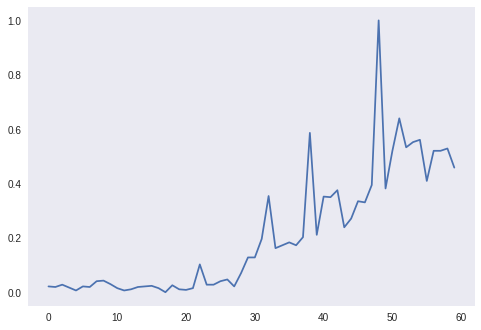

In [ ]:
#Vietnam
vn_train_gen= prepare_data(Vietnam, "2020-01-03","2021-03-31","New_cases")
vn_test_gen = prepare_data(Vietnam, "2021-04-01","2021-06-07","New_cases")


train, val = train_test_split(vn_train_gen, 0.8)
vn_x_train, vn_y_train = prepare_data_model(train, step)
vn_x_val, vn_y_val = prepare_data_model(val, step)
vn_x_test, vn_y_test = prepare_data_model(vn_test_gen, step)
plt.style.use('seaborn')
plt.grid(False)
plt.plot(vn_y_test.copy().flatten())
print(vn_x_train.shape, vn_x_val.shape, vn_x_test.shape)

(356, 7, 1) (83, 7, 1) (60, 7, 1)


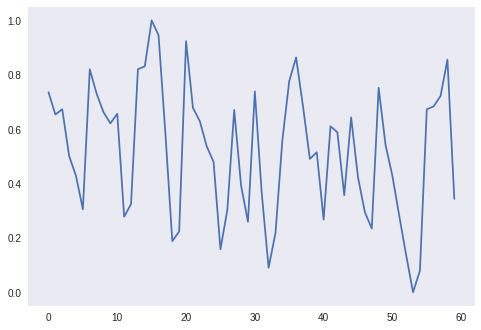

In [ ]:
#Korea
kr_train_gen= prepare_data(Korea, "2020-01-03","2021-03-31","New_cases")
kr_test_gen = prepare_data(Korea, "2021-04-01","2021-06-07","New_cases")


train, val = train_test_split(kr_train_gen, 0.8)
kr_x_train, kr_y_train = prepare_data_model(train, step)
kr_x_val, kr_y_val = prepare_data_model(val, step)
kr_x_test, kr_y_test = prepare_data_model(kr_test_gen, JUMP)
plt.style.use('seaborn')
plt.grid(False)
plt.plot(kr_y_test.copy().flatten())
print(kr_x_train.shape, kr_x_val.shape, kr_x_test.shape)

(357, 7, 1) (83, 7, 1) (60, 7, 1)


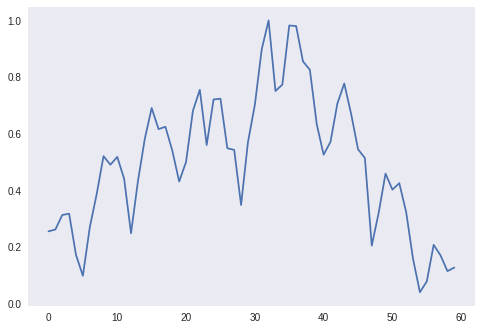

In [ ]:
jp_train_gen= prepare_data(Japan, "2020-01-03","2021-03-31","New_cases")
jp_test_gen = prepare_data(Japan, "2021-04-01","2021-06-07","New_cases")


train, val = train_test_split(jp_train_gen, 0.8)
jp_x_train, jp_y_train = prepare_data_model(train, JUMP)
jp_x_val, jp_y_val = prepare_data_model(val, JUMP)
jp_x_test, jp_y_test = prepare_data_model(jp_test_gen, JUMP)
plt.style.use('seaborn')
plt.grid(False)
plt.plot(jp_y_test.copy().flatten())
print(jp_x_train.shape, jp_x_val.shape, jp_x_test.shape)

#Model Prediction

In this notebook, we will load models trained to show the performance of each model. Briefly, we will have only two types of model: 
1. **Stacked=LSTM**
2. **Hybrid Conv1D-LSTM**

But with some different values of parameters results in different performance, we want to show that things in the following parts.\
In the training phase, we trained these models in 512 epochs, a callback was also set, in order to save weights into .h5 file, which performed best on the validation set (monitoring by the val_loss). We will mark some lines of code written of the training phase.







```
def train(x_train, y_train, x_test, y_test, model, epochs, path):
  mcp = tf.keras.callbacks.ModelCheckpoint(
      path,
      save_best_only = True,
      monitor = 'val_loss',
      mode = 'min',
      save_weights_only = True,
      verbose = 1
  )
  model.fit(
        x_train, y_train,
        epochs = epochs,
        batch_size = 32,
        validation_data = (x_test, y_test),
        callbacks = [mcp]
  )
  return model
```



### Define Model

In [ ]:
def Mymodel(type, n_layers, units, dropout_rate,jump, conv):
    myLSTM, myGRU, myDrop = [], [], []
    Conv_1D = tf.keras.layers.Conv1D(
            filters = 32,
            kernel_size = 1,
            activation = 'relu',
            input_shape = (jump, 1)
    )
    
    for i in range(n_layers):
        lstm = tf.keras.layers.LSTM(units = units[i], name = "LSTM"+str(i+1), 
          return_sequences=False if i == n_layers - 1 else True, input_shape = (jump,1)
        )
        dropout = tf.keras.layers.Dropout(rate = dropout_rate[i],name = "Dropout"+str(i+1))
        myLSTM.append(lstm)
        myDrop.append(dropout)
    
    model = tf.keras.Sequential()
    if conv == True:
      model.add(Conv_1D)
    for i in range(n_layers):
      if type == "LSTM":
        model.add(myLSTM[i])
        model.add(myDrop[i])
      else:
        model.add(myGRU[i])
        model.add(myDrop[i])
    model.add(tf.keras.layers.Dense(units = 128)),
    model.add(tf.keras.layers.Dense(units = 128)),
    model.add(tf.keras.layers.Dense(units = 1))
    model.compile(loss = 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01), metrics = [tf.keras.metrics.RootMeanSquaredError(), 'mean_absolute_error'])

    return model

In [ ]:
def visualize(actual, predict):
    x = actual.copy().flatten()
    x_hat = predict.copy().flatten()
    fig, ax = plt.subplots()
    plt.grid(False)
    plt.title("Comparison between actual and predicted value in the Test set")
    ax.plot(x, label = 'Actual', color = c_actual, linestyle = 'solid')
    ax.plot(x_hat, label = 'Predicted', color = c_predict, linestyle = 'solid')
    plt.xlabel('Days')
    plt.legend()

def performance(evaluation):
  type1 = [evaluation[0][1], evaluation[1][1]]
  type2 = [evaluation[2][1], evaluation[3][1]]
  x = np.arange(len(type1))
  plt.bar(x-0.05, type1, 0.1, label = 'Conv1D-LSTM')
  plt.bar(x+0.05, type2,0.1, label = 'Stacked-LSTM')
  plt.ylabel('Root Mean Squared Error')
  plt.xticks(ticks = x, labels = ["[32, 64]", "[64, 128]"])
  plt.xlabel('Units')
  plt.grid(False)
  plt.legend()

In [ ]:
UNITS1 = [32,64]
UNITS2 = [64,128]
DROP = [0.0, 0.1]
JUMP = 7
N_LAYERS = 2
TYPE = "LSTM"

In [ ]:
def get_model():
    lstm_1_1 = Mymodel(TYPE, N_LAYERS, UNITS1, DROP, JUMP, True)
    lstm_1_2 = Mymodel(TYPE, N_LAYERS, UNITS2, DROP, JUMP, True)
    lstm_2_1 = Mymodel(TYPE, N_LAYERS, UNITS1, DROP, JUMP, False)
    lstm_2_2 = Mymodel(TYPE, N_LAYERS, UNITS2, DROP, JUMP, False)
    model_lstm = [lstm_1_1, lstm_1_2, lstm_2_1, lstm_2_2]
    return model_lstm

In [ ]:
def future_cases(history, period, model):
    predictions = []
    for i in range(period):
        x = history[i:, :]
        test = np.array([x])
        pred = model.predict(test)
        history = np.concatenate((history, pred), axis = 0)
        predictions.append(pred)
    return np.array(predictions)

def _future(actual, predict, future, period):
    temp = np.linspace(59,88,period)
    fig, ax = plt.subplots()
    plt.grid(False)
    _actual = actual.copy().flatten()
    _predict = predict.copy().flatten()
    a = future.copy().flatten()
    ax.plot(actual, color = c_actual, label = 'Actual', linestyle = 'solid')
    ax.plot(pred, color = c_predict, label = 'Predicted', linestyle = 'solid')
    ax.plot(temp,a, color = 'red', label = 'Future', linestyle = 'dotted')
    plt.xlabel('Days')
    plt.ylabel("New Cases")
    plt.legend()
    plt.title("Future prediction in June and July 2021")
def visual_future(model, data, history, period): 
    pred = model.predict(data)
    actual = history.copy()
    tmp = data[len(data)-1]
    a = our_future(tmp, period, model)
    _future(actual, pred, a, period)

##Global

#####Testing

In [ ]:
global_model_lstm = get_model()

In [ ]:
for i in range(4):
   global_model_lstm[i].load_weights('/content/Global_model-v'+str(i+1)+'.h5')

In [ ]:
evaluation = []
prediction = []
for model in global_model_lstm:  
    eva = model.evaluate(wld_x_test, wld_y_test)
    pred = model.predict(wld_x_test)
    evaluation.append(eva)
    prediction.append(pred)

2/2 [==============================] - 1s 11ms/step - loss: 0.0095 - root_mean_squared_error: 0.0975 - mean_absolute_error: 0.0838


In [ ]:
global_model = global_model_lstm[3]

####Global Model Version 1.1 - Conv1D-LSTM
Name: Global_model-v1_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]


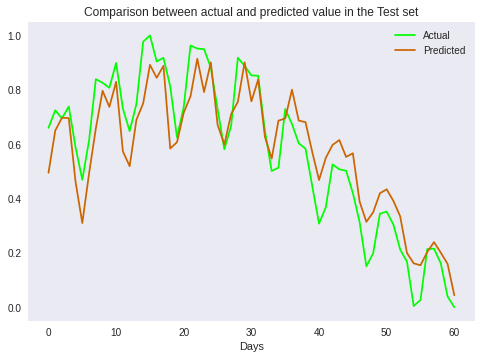

In [ ]:
visualize(wld_y_test, prediction[0])

####Global Model Version 1.2 - Conv1D-LSTM
Name: Global_model-v1_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

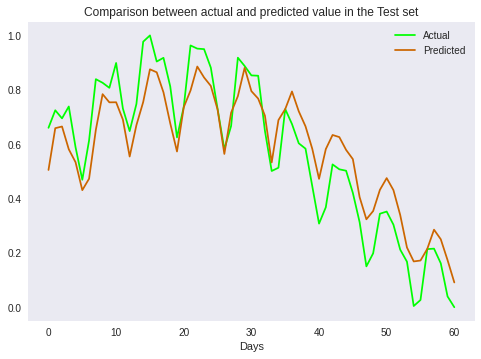

In [ ]:
visualize(wld_y_test, prediction[1])

####Global Model Version 2.1 - LSTM
Name: Global_model-v2_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]

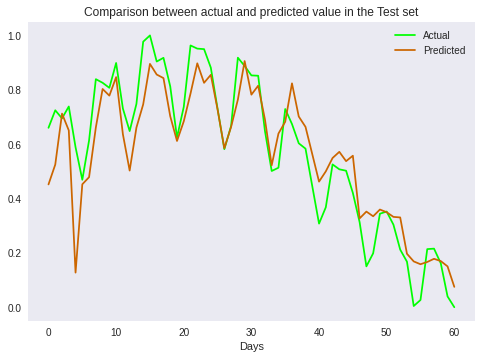

In [ ]:
visualize(wld_y_test, prediction[2])

####Global Model Version 2.2 - LSTM
Name: Global_model-v2_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

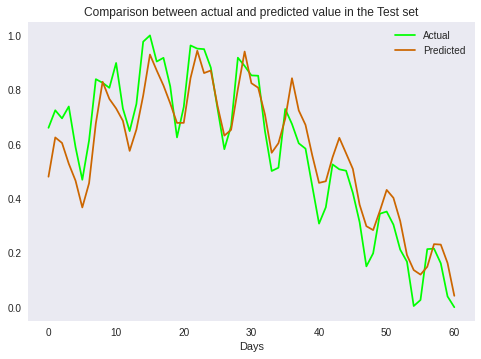

In [ ]:
visualize(wld_y_test, prediction[3])

####**Inference**

In [ ]:
PERIOD = 30

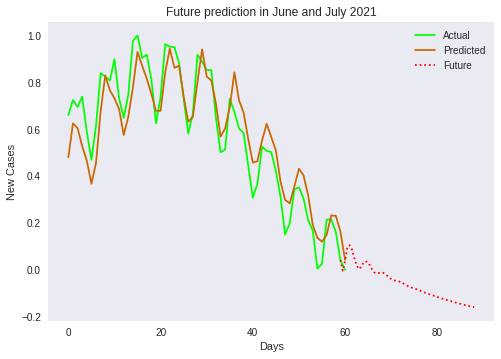

In [ ]:
visual_future(global_model, wld_x_test, wld_y_test, PERIOD)

## USA - India - Brazil

### USA

In [ ]:
us_model_lstm  = get_model()

In [ ]:
for i in range(4):
   us_model_lstm[i].load_weights('/content/US_model-v'+str(i+1)+'.h5')

In [ ]:
prediction = []
evaluation = []

for model in us_model_lstm:  
    eva = model.evaluate(us_x_test, us_y_test)
    pred = model.predict(us_x_test)
    evaluation.append(eva)
    prediction.append(pred)

2/2 [==============================] - 4s 12ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114 - mean_absolute_error: 0.0874


In [ ]:
us_model = us_model_lstm[2]

####USA Model Version 1.1 - Conv1D-LSTM
Name: US_model-v1_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]


[0.011738229542970657, 0.10834310948848724, 0.08304917067289352]

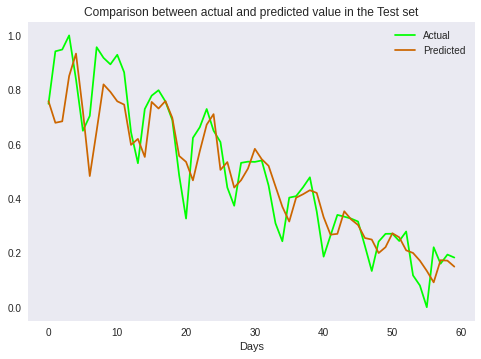

In [ ]:
visualize(us_y_test, prediction[0])
evaluation[0]

####USA Model Version 1.2 - Conv1D-LSTM
Name: US_model-v1_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

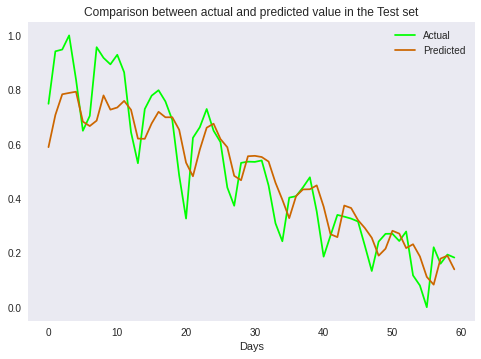

In [ ]:
visualize(us_y_test, prediction[1])

####USA Model Version 2.1 - LSTM
Name: US_model-v2_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]

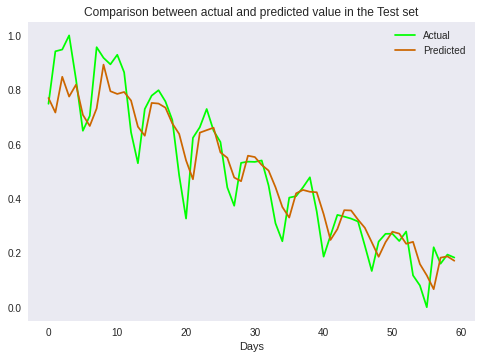

In [ ]:
visualize(us_y_test, prediction[2])

####USA Model Version 2.2 - LSTM
Name: US_model-v2_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

[0.0124017633497715, 0.11136320233345032, 0.0874323695898056]

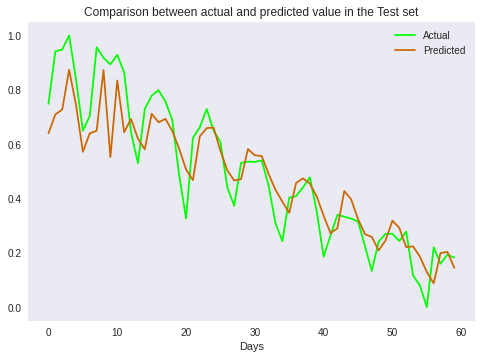

In [ ]:
visualize(us_y_test, prediction[3])
evaluation[3]

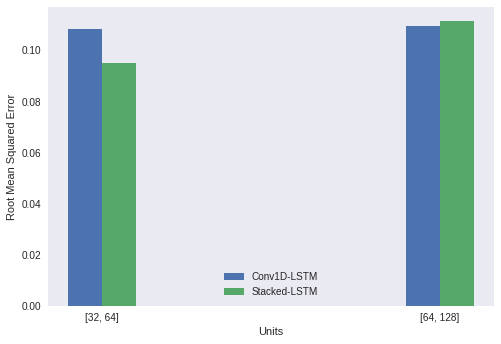

In [ ]:
performance(evaluation)

####**Inference**

In [ ]:
visual_future(us_model, us_x_test, us_y_test, PERIOD)

### India

In [ ]:
ind_model_lstm = get_model()

In [ ]:
for i in range(4):
   ind_model_lstm[i].load_weights('/content/Ind_model-v'+str(i+1)+'.h5')


In [ ]:
prediction = []
evaluation = []

for model in ind_model_lstm:  
    eva = model.evaluate(ind_x_test, ind_y_test)
    pred = model.predict(ind_x_test)
    evaluation.append(eva)
    prediction.append(pred)

2/2 [==============================] - 1s 12ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407 - mean_absolute_error: 0.1215


In [ ]:
ind_model = ind_model_lstm[0]

####India Model Version 1.1 - Conv1D-LSTM
Name: Ind_model-v1_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]


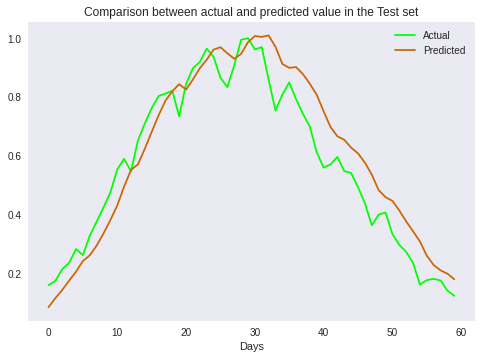

In [ ]:
visualize(ind_y_test, prediction[0])

####India Model Version 1.2 - Conv1D-LSTM
Name: Ind_model-v1_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

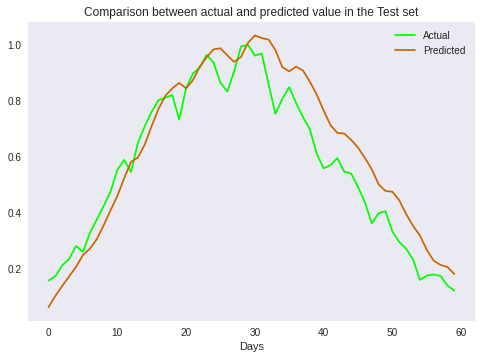

In [ ]:
visualize(ind_y_test, prediction[1])

####India Model Version 2.1 - LSTM
Name: Ind_model-v2_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]

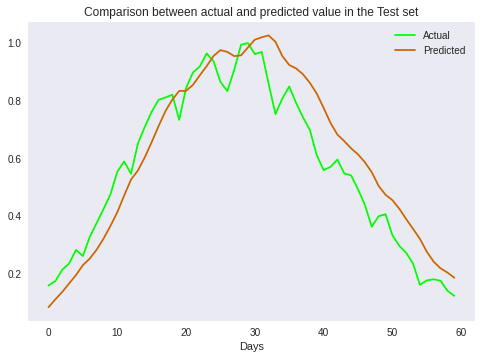

In [ ]:
visualize(ind_y_test, prediction[2])

####India Model Version 2.2 - LSTM
Name: Ind_model-v2_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

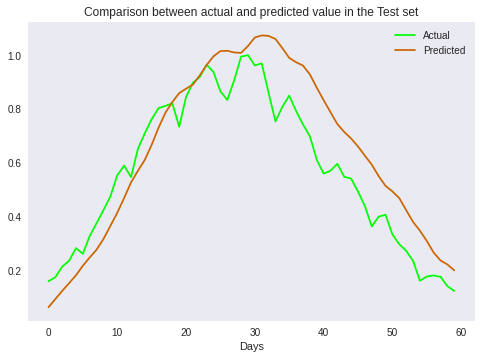

In [ ]:
visualize(ind_y_test, prediction[3])

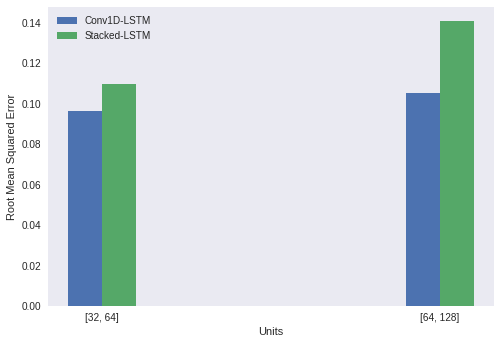

In [ ]:
performance(evaluation)

####**Inference**

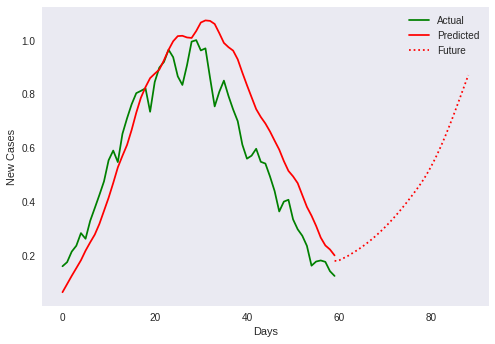

In [ ]:
visual_future(ind_model, ind_x_test, ind_y_test, PERIOD)

### Brazil

In [ ]:
bra_model_lstm = get_model()

In [ ]:
for i in range(4):
   bra_model_lstm[i].load_weights('/content/Bra_model-v'+str(i+1)+'.h5')


In [ ]:
prediction = []
evaluation = []

for model in bra_model_lstm:  
    eva = model.evaluate(bra_x_test, bra_y_test)
    pred = model.predict(bra_x_test)
    evaluation.append(eva)
    prediction.append(pred)

2/2 [==============================] - 1s 10ms/step - loss: 0.0235 - root_mean_squared_error: 0.1532 - mean_absolute_error: 0.1165


In [ ]:
bra_model = bra_model_lstm[3].load_weights('/content/Bra_model-v4.h5')

####Brazil Model Version 1.1 - Conv1D-LSTM
Name: Bra_model-v1_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]


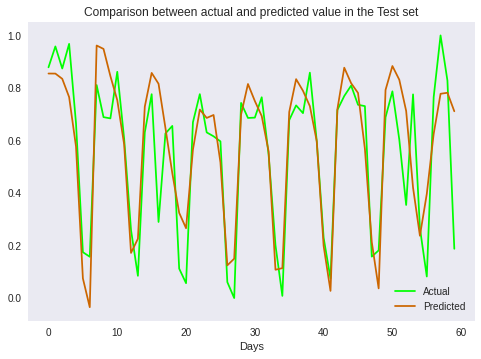

In [ ]:
visualize(bra_y_test, prediction[0])

####Brazil Model Version 1.2 - Conv1D-LSTM
Name: Bra_model-v1_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

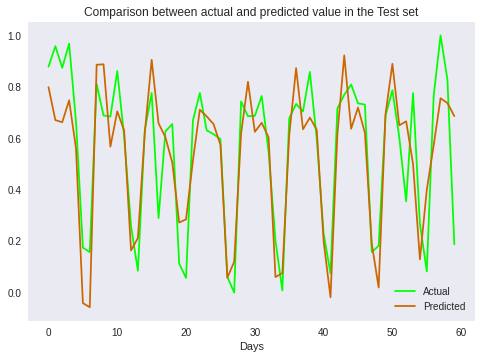

In [ ]:
visualize(bra_y_test, prediction[1])

####Brazil Model Version 2.1 - LSTM
Name: Bra_model-v2_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]

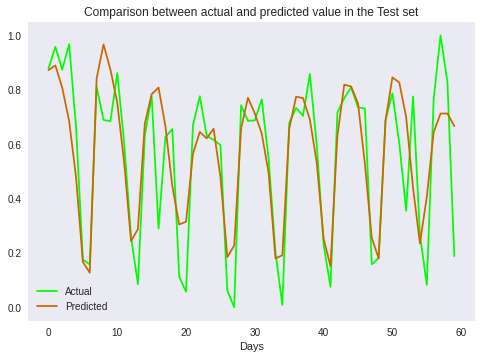

In [ ]:
visualize(bra_y_test, prediction[2])

####Brazil Model Version 2.2 - LSTM
Name: Bra_model-v2_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

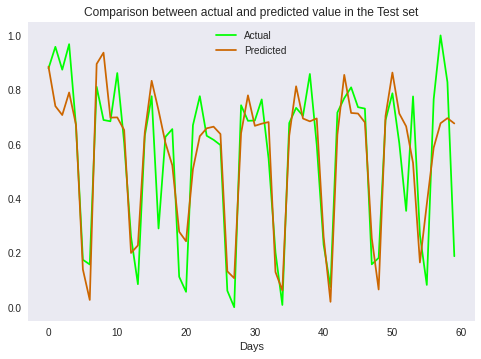

In [ ]:
visualize(bra_y_test, prediction[3])

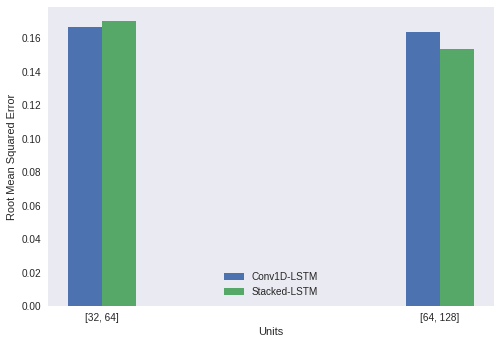

In [ ]:
performance(evaluation)

####**Inference**

In [ ]:
visual_future(us_model, us_x_test, us_y_test, PERIOD)

## Vietnam - Korea - Japan

### Vietnam

In [ ]:
vn_model_lstm = get_model()

In [ ]:
for i in range(4):
   vn_model_lstm[i].load_weights('/content/VN_model-v'+str(i+1)+'.h5')


In [ ]:
prediction = []
evaluation = []

for model in vn_model_lstm:  
    eva = model.evaluate(vn_x_test, vn_y_test)
    pred = model.predict(vn_x_test)
    evaluation.append(eva)
    prediction.append(pred)

2/2 [==============================] - 1s 16ms/step - loss: 0.0253 - root_mean_squared_error: 0.1589 - mean_absolute_error: 0.0956


In [ ]:
vn_model = vn_model_lstm[1]

####Vietnam Model Version 1.1 - Conv1D-LSTM
Name: VN_model-v1_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]

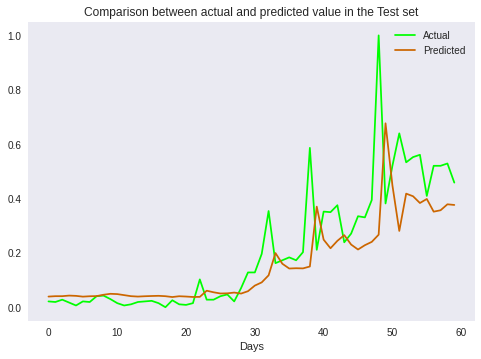

In [ ]:
visualize(vn_y_test, prediction[0])

####Vietnam Model Version 1.2 - Conv1D-LSTM
Name: VN_model-v1_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

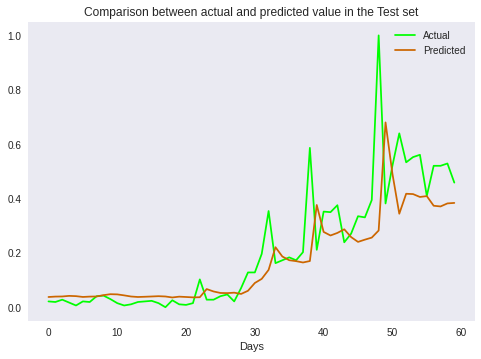

In [ ]:
visualize(vn_y_test, prediction[1])

####Vietnam Model Version 2.1 - LSTM
Name: VN_model-v2_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]

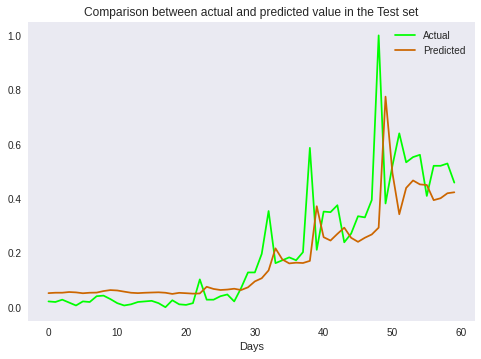

In [ ]:
visualize(vn_y_test, prediction[2])

####Vietnam Model Version 2.2 - LSTM
Name: VN_model-v2_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

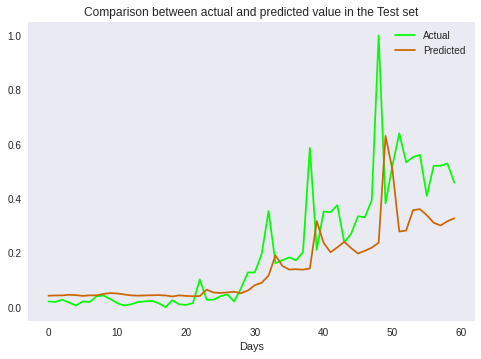

In [ ]:
visualize(vn_y_test, prediction[3])

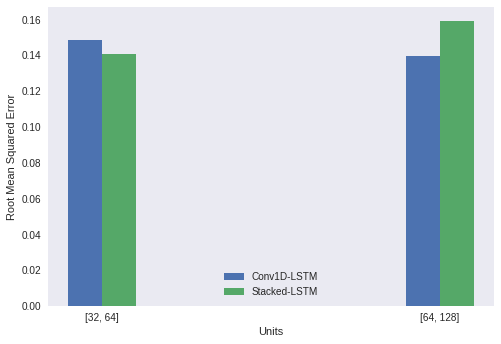

In [ ]:
performance(evaluation)

####**Inference**

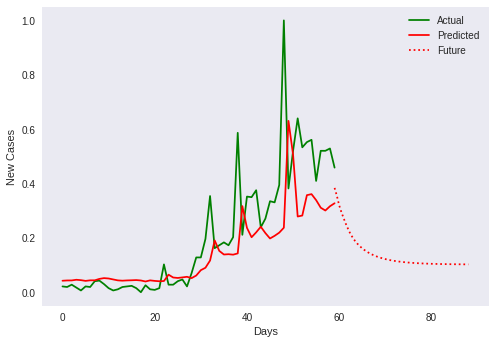

In [ ]:
visual_future(vn_model, vn_x_test, vn_y_test, PERIOD)

### Korea

In [ ]:
kr_model_lstm = get_model()

In [ ]:
for i in range(4):
   kr_model_lstm[i].load_weights('/content/KR_model-v'+str(i+1)+'.h5')


In [ ]:
prediction = []
evaluation = []

for model in kr_model_lstm:  
    eva = model.evaluate(kr_x_test, kr_y_test)
    pred = model.predict(kr_x_test)
    evaluation.append(eva)
    prediction.append(pred)

2/2 [==============================] - 1s 12ms/step - loss: 0.0615 - root_mean_squared_error: 0.2480 - mean_absolute_error: 0.1956


In [ ]:
kr_model = kr_model_lstm[2]

####Korea Model Version 1.1 - Conv1D-LSTM
Name: KR_model-v1_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]

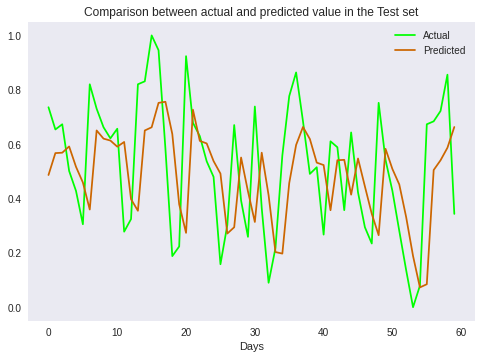

In [ ]:
visualize(kr_y_test, prediction[0])

####Korea Model Version 1.2 - Conv1D-LSTM
Name: KR_model-v1_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

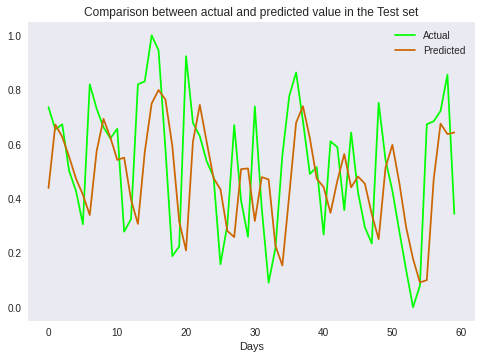

In [ ]:
visualize(kr_y_test, prediction[1])

####Korea Model Version 2.1 - LSTM
Name: KR_model-v2_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]

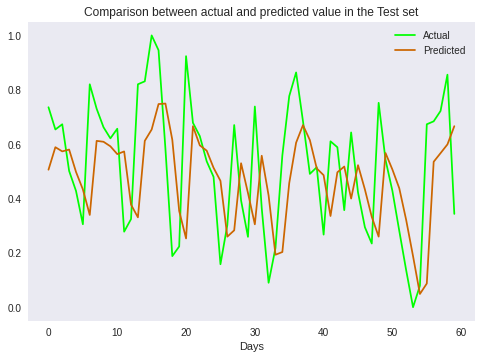

In [ ]:
visualize(kr_y_test, prediction[2])

####Korea Model Version 2.2 - LSTM
Name: KR_model-v2_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

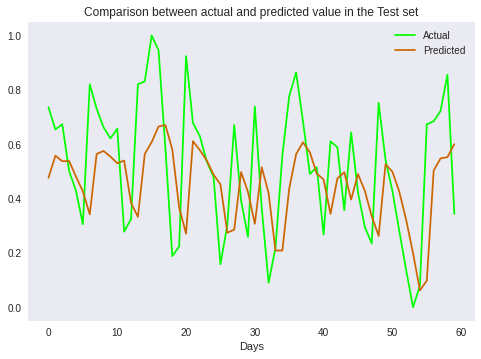

In [ ]:
visualize(kr_y_test, prediction[3])

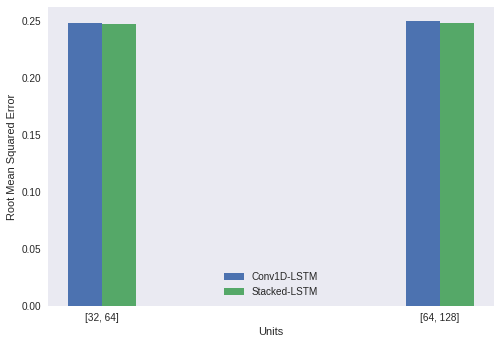

In [ ]:
performance(evaluation)

####**Inference**

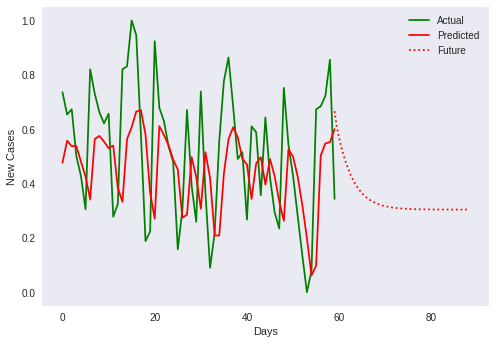

In [ ]:
visual_future(kr_model, kr_x_test, kr_y_test, PERIOD)

### Japan

In [ ]:
jp_model_lstm = get_model()

In [ ]:
for i in range(4):
   jp_model_lstm[i].load_weights('/content/JP_model-v'+str(i+1)+'.h5')


In [ ]:
prediction = []
evaluation = []

for model in jp_model_lstm:  
    eva = model.evaluate(jp_x_test, jp_y_test)
    pred = model.predict(jp_x_test)
    evaluation.append(eva)
    prediction.append(pred)

2/2 [==============================] - 1s 11ms/step - loss: 0.0295 - root_mean_squared_error: 0.1718 - mean_absolute_error: 0.1347


In [ ]:
jp_model = jp_model_lstm[0]

####Japan Model Version 1.1 - Conv1D-LSTM
Name: JP_model-v1_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]

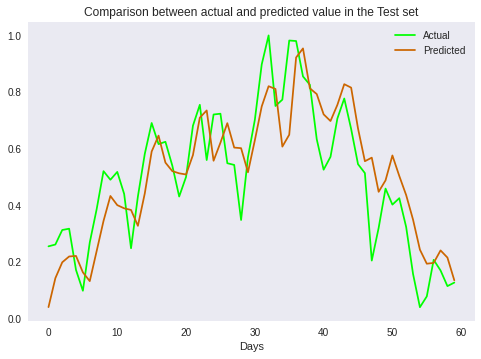

In [ ]:
visualize(jp_y_test, prediction[0])

####Japan Model Version 1.2 - Conv1D-LSTM
Name: JP_model-v1_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

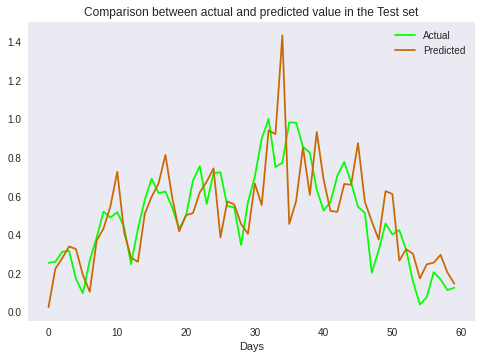

In [ ]:
visualize(jp_y_test, prediction[1])

####Japan Model Version 2.1 - LSTM
Name: JP_model-v2_1.h5\
Number of layers: 2\
Units = [32, 64]\
Dropout = [0.0, 0.1]

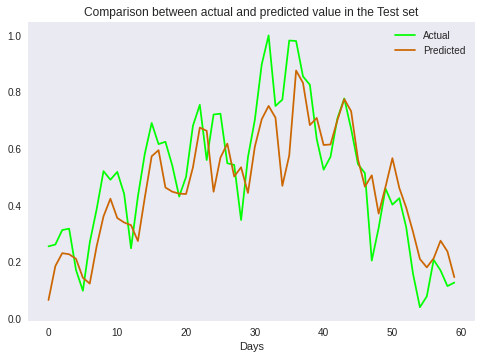

In [ ]:
visualize(jp_y_test, prediction[2])

####Japan Model Version 2.2 - LSTM
Name: JP_model-v2_2.h5\
Number of layers: 2\
Units = [64, 128]\
Dropout = [0.1, 0.2]

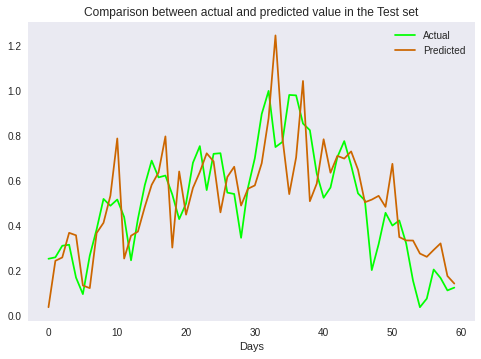

In [ ]:
visualize(jp_y_test, prediction[3])

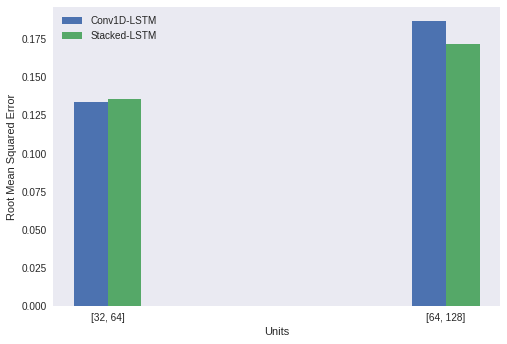

In [ ]:
performance(evaluation)

####**Inference**

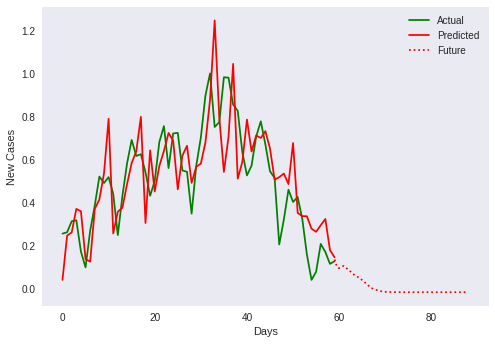

In [ ]:
visual_future(jp_model, jp_x_test, jp_y_test, PERIOD)

# -Created by Quang Nguyen-
If you have any question, please feel free to contact the representative of the team:\
Contact: quang.nguyencse272@hcmut.edu.vn